In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

In [20]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_8/alabama/2022_11_15_10_25_28/count_data/

deaths.csv                             risk_exposure_time.hdf
deaths.hdf                             sbp_medication_person_time.csv
healthcare_visits.csv                  sbp_medication_person_time.hdf
healthcare_visits.hdf                  state_person_time.csv
ldlc_medication_person_time.csv        state_person_time.hdf
ldlc_medication_person_time.hdf        transition_count.csv
outreach_intervention_person_time.csv  transition_count.hdf
outreach_intervention_person_time.hdf  ylds.csv
population.csv                         ylds.hdf
population.hdf                         ylls.csv
risk_exposure_time.csv                 ylls.hdf


In [11]:
sim_results_dir = '/ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_8/alabama/2022_11_15_10_25_28/count_data/'

In [14]:
risk_exp = pd.read_csv(sim_results_dir + 'risk_exposure_time.csv')
sbp = risk_exp.loc[risk_exp['risk']=='high_systolic_blood_pressure']
sbp.head()

,Unnamed: 0,sex,year,risk,measure,input_draw,scenario,age,value
450,450,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,25_to_29,3.209533e+06
451,451,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,outreach_100,25_to_29,3.208678e+06
452,452,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,outreach_50,25_to_29,3.209129e+06
453,453,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,baseline,30_to_34,3.369457e+06
454,454,female,2023,high_systolic_blood_pressure,risk_exposure_time,29,outreach_100,30_to_34,3.367655e+06


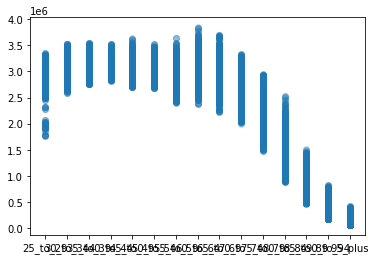

In [19]:
plt.scatter(sbp.age, sbp.value, alpha=0.2)

## Trying the Interactive Sim

In [36]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)
import seaborn as sns

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages

In [22]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [23]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2035
                                  }
                              }
                          }
                        )
sim.setup()


2022-12-28 13:21:06.272 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2022-12-28 13:21:06.297 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2022-12-28 13:21:06.299 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2022-12-28 13:21:06.307 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2022-12-28 13:21:06.775 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2022-12-28 13:21:06.775 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2022-12-28 13:21:07.158 | DEBUG    | vivarium.framework.values:_regis

In [24]:
pop0 = sim.get_population()
pop0.head()

,tracked,exit_time,sex,alive,age,location,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,sbp_medication_adherence,polypill,ldlc_medication_adherence,ldlc_medication,ldlc_multiplier,sbp_multiplier,outreach,sbp_medication,scheduled_date,visit_type
0,True,NaT,Male,alive,74.022381,Alabama,2034-12-04,not_dead,0.0,0.0,...,cat3,cat2,cat1,low_intensity,1.0000,1.0,cat2,no_treatment,NaT,none
1,True,NaT,Male,alive,49.761882,Alabama,2034-12-04,not_dead,0.0,0.0,...,cat3,cat2,cat2,low_intensity,1.0000,1.0,cat2,no_treatment,NaT,none
2,True,NaT,Female,alive,7.791050,Alabama,2034-12-04,not_dead,0.0,0.0,...,cat3,cat2,cat1,no_treatment,1.0000,1.0,cat2,no_treatment,NaT,none
3,True,NaT,Female,alive,78.819458,Alabama,2034-12-04,not_dead,0.0,0.0,...,cat1,cat2,cat3,high_intensity,1.5125,1.0,cat2,no_treatment,2035-01-09 17:30:09.424800000,none
4,True,NaT,Male,alive,34.252380,Alabama,2034-12-04,not_dead,0.0,0.0,...,cat1,cat2,cat1,no_treatment,1.0000,1.0,cat2,no_treatment,2035-01-20 06:19:39.396806400,none


In [25]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl_cholesterol'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                  ], axis=1)
data1.head()

,tracked,exit_time,sex,alive,age,location,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_medication,ldlc_multiplier,sbp_multiplier,outreach,sbp_medication,scheduled_date,visit_type,high_ldl_cholesterol,high_sbp,high_bmi
0,True,NaT,Male,alive,74.022381,Alabama,2034-12-04,not_dead,0.0,0.0,...,low_intensity,1.0000,1.0,cat2,no_treatment,NaT,none,2.482532,132.675057,33.311040
1,True,NaT,Male,alive,49.761882,Alabama,2034-12-04,not_dead,0.0,0.0,...,low_intensity,1.0000,1.0,cat2,no_treatment,NaT,none,3.117389,137.848350,29.032447
2,True,NaT,Female,alive,7.791050,Alabama,2034-12-04,not_dead,0.0,0.0,...,no_treatment,1.0000,1.0,cat2,no_treatment,NaT,none,0.000000,50.000000,5.000000
3,True,NaT,Female,alive,78.819458,Alabama,2034-12-04,not_dead,0.0,0.0,...,high_intensity,1.5125,1.0,cat2,no_treatment,2035-01-09 17:30:09.424800000,none,1.222076,114.221697,27.408606
4,True,NaT,Male,alive,34.252380,Alabama,2034-12-04,not_dead,0.0,0.0,...,no_treatment,1.0000,1.0,cat2,no_treatment,2035-01-20 06:19:39.396806400,none,2.103276,123.202140,17.133231


In [28]:
data1 = data1.loc[(data1.alive == 'alive') & (data1.age > 25)]

[Text(0.5, 0, 'SBP'), Text(0, 0.5, 'Percent of Simulants')]

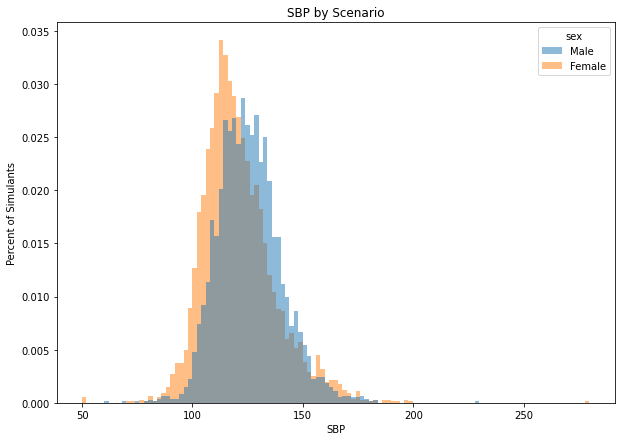

In [53]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=data1, x='high_sbp', hue='sex', stat='probability', edgecolor=None)
ax.set_title('SBP by Scenario')
ax.set(xlabel='SBP', ylabel='Percent of Simulants')

In [80]:
data1['sbp_binary'] = np.where(data1['high_sbp']<120,'Normal',np.where(data1['high_sbp']<130,'Test','Uncontrolled'))
data1.head()

,tracked,exit_time,sex,alive,age,location,entrance_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_multiplier,sbp_multiplier,outreach,sbp_medication,scheduled_date,visit_type,high_ldl_cholesterol,high_sbp,high_bmi,sbp_binary
0,True,NaT,Male,alive,74.022381,Alabama,2034-12-04,not_dead,0.0,0.0,...,1.0000,1.0,cat2,no_treatment,NaT,none,2.482532,132.675057,33.311040,Uncontrolled
1,True,NaT,Male,alive,49.761882,Alabama,2034-12-04,not_dead,0.0,0.0,...,1.0000,1.0,cat2,no_treatment,NaT,none,3.117389,137.848350,29.032447,Uncontrolled
3,True,NaT,Female,alive,78.819458,Alabama,2034-12-04,not_dead,0.0,0.0,...,1.5125,1.0,cat2,no_treatment,2035-01-09 17:30:09.424800000,none,1.222076,114.221697,27.408606,Normal
4,True,NaT,Male,alive,34.252380,Alabama,2034-12-04,not_dead,0.0,0.0,...,1.0000,1.0,cat2,no_treatment,2035-01-20 06:19:39.396806400,none,2.103276,123.202140,17.133231,Test
6,True,NaT,Female,alive,37.723138,Alabama,2034-12-04,not_dead,0.0,0.0,...,1.0000,1.0,cat2,no_treatment,NaT,none,2.567958,128.910470,8.695269,Test


In [106]:
count1 = len(data1.loc[data1.sbp_binary == 'Normal'])/len(data1)
count2 = 2000/len(data1)
#count2 = len(data1.loc[data1.sbp_binary == 'Test'])
count3 = len(data1.loc[data1.sbp_binary == 'Uncontrolled'])/len(data1)
height = [count1, count2, count3]
height

[0.45775586353944564, 0.26652452025586354, 0.5422441364605544]

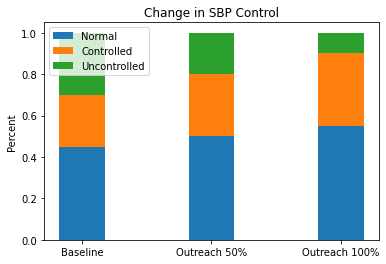

In [117]:
labels = ['Baseline', 'Outreach 50%', 'Outreach 100%']
Normal = [0.45, 0.5, 0.55]
Controlled = [0.25, 0.3, 0.35]
Uncontrolled = [0.3, 0.2, 0.1]
width = 0.35       # the width of the bars: can also be len(x) sequence
bottom2 = [0.7,0.8,0.9]

fig, ax = plt.subplots()

ax.bar(labels, Normal, width, label='Normal')
ax.bar(labels, Controlled, width, bottom=Normal,label='Controlled')
ax.bar(labels, Uncontrolled, width, bottom=bottom2,label='Uncontrolled')

ax.set_ylabel('Percent')
ax.set_title('Change in SBP Control')
ax.legend()

plt.show()

In [139]:
dalys = {'State':['Alabama','Alaska','Arizona','Arkansas','Calfornia','Colorado','Conneticut','Delware','Florida','Hawaii','Idaho','Indiana','Iowa','Kanasa','Kentucky','Lousiana'], 
         'Polypill':[7,11,10,11,12,14,17,25,22,28,30,34,36,42,45,50],
         'Outreach':[3,5,8,10,13,15,19,19,21,24,25,25,27,29,30,33],
        'Year':[2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038]}
dalys = pd.DataFrame(dalys)

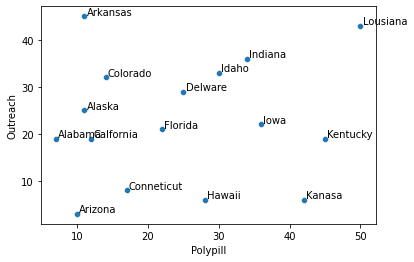

In [136]:
sns.scatterplot(data=dalys,x='Polypill',y='Outreach')
for i in range(dalys.shape[0]):
    plt.text(x=dalys.Polypill[i]+0.3,y=dalys.Outreach[i]+0.3,s=dalys.State[i], 
          fontdict=dict(color='black',size=10))

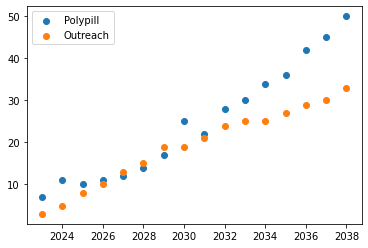

In [143]:
plt.scatter(dalys.Year,dalys.Polypill,label='Polypill')
plt.scatter(dalys.Year,dalys.Outreach,label='Outreach')
plt.legend()

In [146]:
dalys = {'Scenario':['Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Polypill','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach','Outreach'], 
         'Dalys':[7,11,10,11,12,14,17,25,22,28,30,34,36,42,45,50,3,5,8,10,13,15,19,19,21,24,25,25,27,29,30,33]}


[Text(0.5, 0, 'Dalys'), Text(0, 0.5, 'Percent of States')]

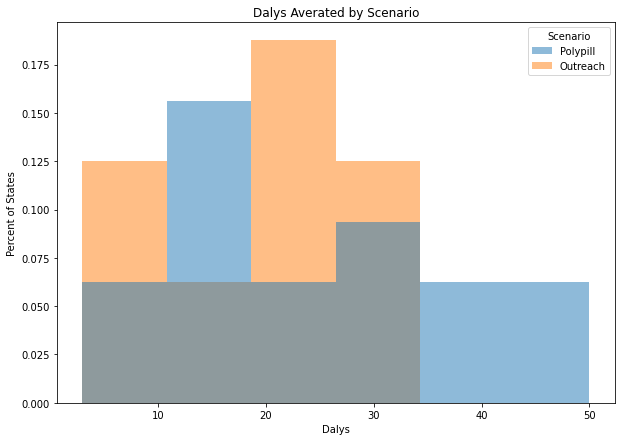

In [147]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.histplot(data=dalys, x='Dalys', hue= 'Scenario', stat='probability', edgecolor=None)
ax.set_title('Dalys Averated by Scenario')
ax.set(xlabel='Dalys', ylabel='Percent of States')